In [58]:
import numpy as np
from IPython.display import Image, display
import pandas as pd
import sqlalchemy as sa
import requests
import json

from pandas.core.interchange.dataframe_protocol import DataFrame


movies_df = pd.read_csv('../../dataset/movies.csv')
actors_df = pd.read_csv('../../dataset/actors.csv')
countries_df = pd.read_csv('../../dataset/countries.csv')
crew_df = pd.read_csv('../../dataset/crew.csv')
genres_df = pd.read_csv('../../dataset/genres.csv')
languages_df = pd.read_csv('../../dataset/languages.csv')
posters_df = pd.read_csv('../../dataset/posters.csv')
releases_df = pd.read_csv('../../dataset/releases.csv')
studios_df = pd.read_csv('../../dataset/studios.csv')
themes_df = pd.read_csv('../../dataset/themes.csv')

movies_df

,id,name,date,tagline,description,minute,rating
0,1000001,Barbie,2023.0,She's everything. He's just Ken.,Barbie and Ken are having the time of their li...,114.0,3.86
1,1000002,Parasite,2019.0,Act like you own the place.,"All unemployed, Ki-taek's family takes peculia...",133.0,4.56
2,1000003,Everything Everywhere All at Once,2022.0,The universe is so much bigger than you realize.,An aging Chinese immigrant is swept up in an i...,140.0,4.30
3,1000004,Fight Club,1999.0,Mischief. Mayhem. Soap.,A ticking-time-bomb insomniac and a slippery s...,139.0,4.27
4,1000005,La La Land,2016.0,Here's to the fools who dream.,"Mia, an aspiring actress, serves lattes to mov...",129.0,4.09
...,...,...,...,...,...,...,...
941592,1941593,神笛,NaN,NaN,NaN,NaN,NaN
941593,1941594,蟲極道蜜団子抗争編 壱ノ巻,NaN,NaN,Shinjuku forest at night. In the sap taverns o...,30.0,NaN
941594,1941595,蟲極道蜜団子抗争編 弐ノ巻,NaN,NaN,"The city that never sleeps, where insects gath...",30.0,NaN
941595,1941596,重生,NaN,NaN,"In a world where order has broken down, darkne...",NaN,NaN


Languages dataframe normalization and sql insertion

# 2.0 Data Analysis
## 2.1 Movies Dataframe Analysis

In [59]:
movies_df

,id,name,date,tagline,description,minute,rating
0,1000001,Barbie,2023.0,She's everything. He's just Ken.,Barbie and Ken are having the time of their li...,114.0,3.86
1,1000002,Parasite,2019.0,Act like you own the place.,"All unemployed, Ki-taek's family takes peculia...",133.0,4.56
2,1000003,Everything Everywhere All at Once,2022.0,The universe is so much bigger than you realize.,An aging Chinese immigrant is swept up in an i...,140.0,4.30
3,1000004,Fight Club,1999.0,Mischief. Mayhem. Soap.,A ticking-time-bomb insomniac and a slippery s...,139.0,4.27
4,1000005,La La Land,2016.0,Here's to the fools who dream.,"Mia, an aspiring actress, serves lattes to mov...",129.0,4.09
...,...,...,...,...,...,...,...
941592,1941593,神笛,NaN,NaN,NaN,NaN,NaN
941593,1941594,蟲極道蜜団子抗争編 壱ノ巻,NaN,NaN,Shinjuku forest at night. In the sap taverns o...,30.0,NaN
941594,1941595,蟲極道蜜団子抗争編 弐ノ巻,NaN,NaN,"The city that never sleeps, where insects gath...",30.0,NaN
941595,1941596,重生,NaN,NaN,"In a world where order has broken down, darkne...",NaN,NaN


#### 2.1.1 - Analyze the distribution of ratings to identify trends.

Removed 853300 rows with nulls or outliers in 'rating'.


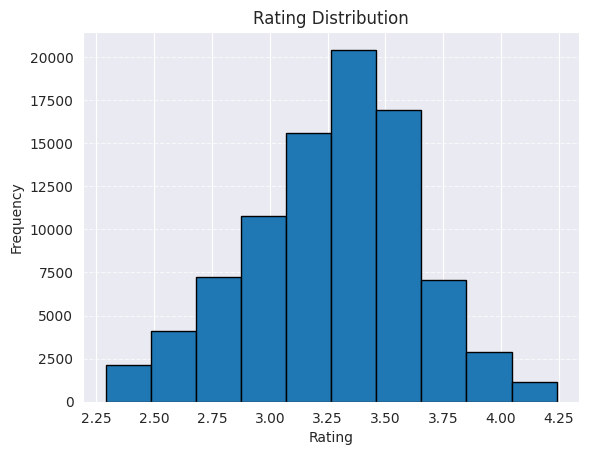

In [60]:
from matplotlib import pyplot as plt

# Filter nulls and outliers for 'rating'
filtered_df = movies_df[movies_df['rating'].notnull()]
q1, q3 = filtered_df['rating'].quantile([0.25, 0.75])
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr
filtered_df = filtered_df[(filtered_df['rating'] >= lower_bound) & (filtered_df['rating'] <= upper_bound)]

print(f"Removed {len(movies_df) - len(filtered_df)} rows with nulls or outliers in 'rating'.")

# Plot
filtered_df['rating'].plot(kind='hist', bins=10, title='Rating Distribution', edgecolor='black')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

#### 2.1.2 - Find the shortest and longest movies, analyze the distribution of movie durations, investigate the relationship between duration and rating. We can see evident outliers, obviously null values can interfere.

Shortest movie: 1.0 minutes
Longest movie: 72000.0 minutes
Average duration: 65.78 minutes


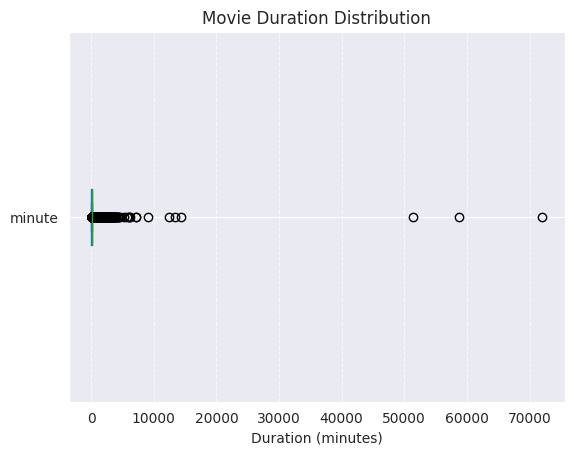

In [61]:
print(f"Shortest movie: {movies_df['minute'].min()} minutes")
print(f"Longest movie: {movies_df['minute'].max()} minutes")
print(f"Average duration: {movies_df['minute'].mean():.2f} minutes")

movies_df['minute'].plot(kind='box', vert=False, title='Movie Duration Distribution')
plt.xlabel('Duration (minutes)')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

#### 2.1.2.1 - If we remove those elements we can see a more accurately plot.

Removed 193262 rows with nulls or outliers in 'minute'.
Shortest movie: 1.0 minutes
Longest movie: 207.0 minutes
Average duration: 58.19 minutes


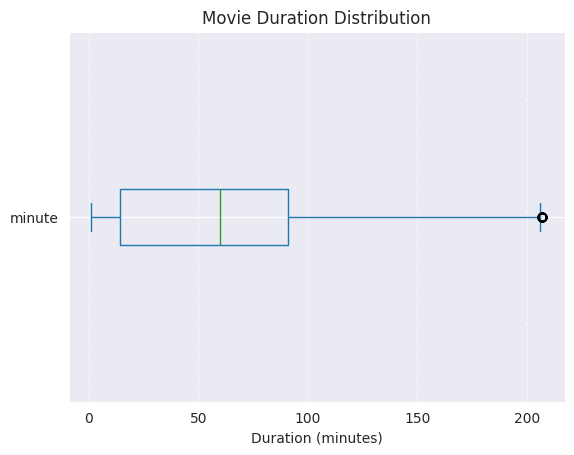

In [62]:
# Filter nulls and outliers for 'minute'
filtered_df = movies_df[movies_df['minute'].notnull()]
q1, q3 = filtered_df['minute'].quantile([0.25, 0.75])
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr
filtered_df = filtered_df[(filtered_df['minute'] >= lower_bound) & (filtered_df['minute'] <= upper_bound)]

print(f"Removed {len(movies_df) - len(filtered_df)} rows with nulls or outliers in 'minute'.")

# Summary
print(f"Shortest movie: {filtered_df['minute'].min()} minutes")
print(f"Longest movie: {filtered_df['minute'].max()} minutes")
print(f"Average duration: {filtered_df['minute'].mean():.2f} minutes")

# Plot
filtered_df['minute'].plot(kind='box', vert=False, title='Movie Duration Distribution')
plt.xlabel('Duration (minutes)')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

#### 2.1.3 - Investigate how the duration of a movie (minute) correlates with its rating (rating). This can reveal if longer movies tend to have better ratings.

Removed rows with nulls or outliers in 'minute' or 'rating': 871037.


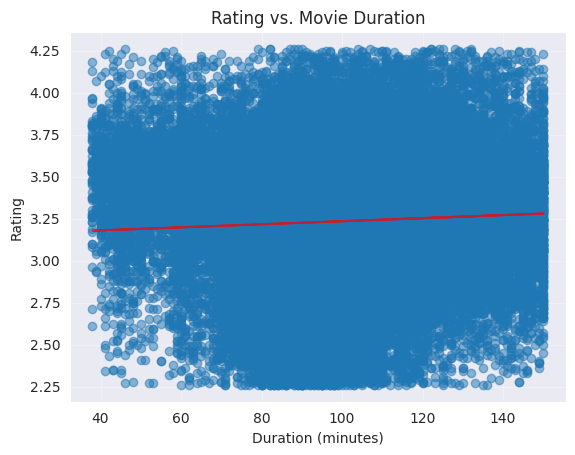

In [63]:
# Filter nulls and outliers for 'minute' and 'rating'
filtered_df = movies_df.dropna(subset=['minute', 'rating'])
q1_min, q3_min = filtered_df['minute'].quantile([0.25, 0.75])
iqr_min = q3_min - q1_min
lower_min = q1_min - 1.5 * iqr_min
upper_min = q3_min + 1.5 * iqr_min

q1_rat, q3_rat = filtered_df['rating'].quantile([0.25, 0.75])
iqr_rat = q3_rat - q1_rat
lower_rat = q1_rat - 1.5 * iqr_rat
upper_rat = q3_rat + 1.5 * iqr_rat

filtered_df = filtered_df[(filtered_df['minute'] >= lower_min) & (filtered_df['minute'] <= upper_min) &
                          (filtered_df['rating'] >= lower_rat) & (filtered_df['rating'] <= upper_rat)]

print(f"Removed rows with nulls or outliers in 'minute' or 'rating': {len(movies_df) - len(filtered_df)}.")

# Scatter plot
plt.scatter(filtered_df['minute'], filtered_df['rating'], alpha=0.5)
plt.title('Rating vs. Movie Duration')
plt.xlabel('Duration (minutes)')
plt.ylabel('Rating')
plt.grid(alpha=0.3)

# Add trend line
import numpy as np
fit = np.polyfit(filtered_df['minute'], filtered_df['rating'], 1)
plt.plot(filtered_df['minute'], fit[0] * filtered_df['minute'] + fit[1], color='red', alpha=0.7)
plt.show()

#### 2.1.4 - Analyze the variability in movie title lengths and identify movies with the shortest and longest titles.

Removed 44475 rows with nulls or outliers in 'title_length'.


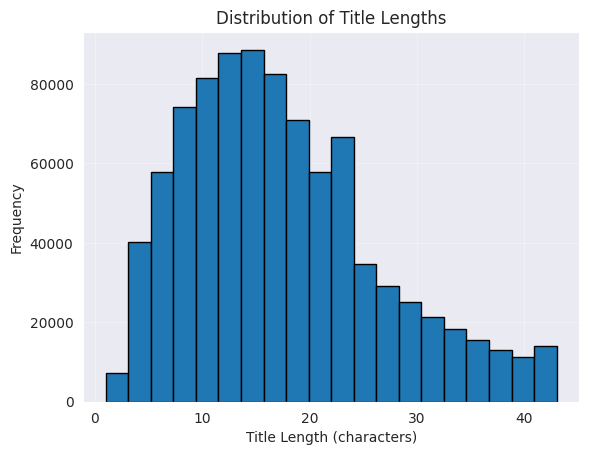

In [64]:
# Filter nulls for 'name' and explicitly create a copy
filtered_df = movies_df[movies_df['name'].notnull()].copy()
filtered_df['title_length'] = filtered_df['name'].str.len()

# Remove outliers for title length
q1, q3 = filtered_df['title_length'].quantile([0.25, 0.75])
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr
filtered_df = filtered_df[(filtered_df['title_length'] >= lower_bound) & (filtered_df['title_length'] <= upper_bound)]

print(f"Removed {len(movies_df) - len(filtered_df)} rows with nulls or outliers in 'title_length'.")

# Plot
filtered_df['title_length'].plot(kind='hist', bins=20, title='Distribution of Title Lengths', edgecolor='black')
plt.xlabel('Title Length (characters)')
plt.ylabel('Frequency')
plt.grid(alpha=0.3)
plt.show()

#### 2.1.5 - Explore potential correlations between numerical variables like minute and rating.

In [65]:
# Filter nulls and outliers for 'minute' and 'rating'
filtered_df = movies_df.dropna(subset=['minute', 'rating'])
correlation = filtered_df['rating'].corr(filtered_df['minute'])
print(f"Correlation between Rating and Movie Duration: {correlation:.2f}")

Correlation between Rating and Movie Duration: 0.05


#### 2.1.6 - Identify the highest-rated and lowest-rated movies.

Top 10 Longest Highly Rated Movies:
                                                   name  minute  rating
863                                            Harakiri   135.0    4.69
1982                                   Band of Brothers   594.0    4.69
1635                                       Cowboy Bebop   625.0    4.65
3223  No Half Measures: Creating the Final Season of...   135.0    4.65
3376                   Fullmetal Alchemist: Brotherhood  1656.0    4.65
431                                        Come and See   142.0    4.64
3447                                            Monster  1800.0    4.64
5720                                    Planet Earth II   298.0    4.61
535                                       Seven Samurai   207.0    4.60
228                              The Godfather: Part II   202.0    4.59


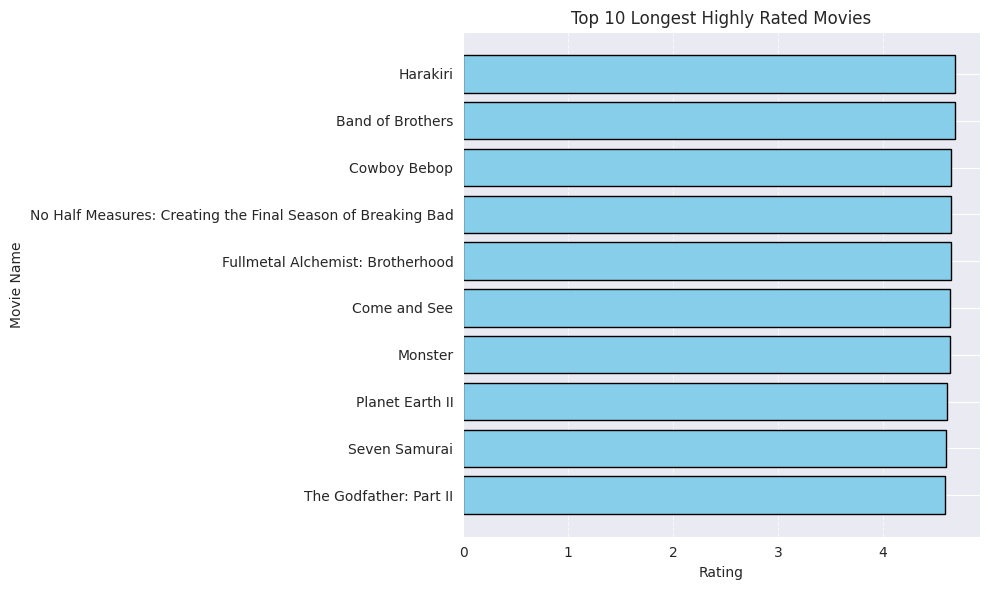


Bottom 5 Movies:
                      name  rating
4916  Dragonball Evolution    0.88
2812              365 Days    1.04
6746    365 Days: This Day    1.06
1917    The Last Airbender    1.07
9105                Swiped    1.09


In [66]:
import pandas as pd
import matplotlib.pyplot as plt

# Filter valid rows for 'minute' and 'rating'
filtered_df = movies_df.dropna(subset=['minute', 'rating'])

# Define a threshold for long movies (e.g., movies longer than 120 minutes)
long_movies = filtered_df[filtered_df['minute'] > 120]

# Find the top 10 longest movies with the highest ratings
top_long_movies = long_movies.nlargest(10, 'rating')

# Display the results
print("Top 10 Longest Highly Rated Movies:")
print(top_long_movies[['name', 'minute', 'rating']])

# Plot the results
plt.figure(figsize=(10, 6))
plt.barh(top_long_movies['name'], top_long_movies['rating'], color='skyblue', edgecolor='black')
plt.xlabel('Rating')
plt.ylabel('Movie Name')
plt.title('Top 10 Longest Highly Rated Movies')
plt.gca().invert_yaxis()  # Invert y-axis for better readability
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Filter nulls for 'rating'
filtered_df = movies_df[movies_df['rating'].notnull()]

# Identify worst movies

worst_movies = filtered_df.nsmallest(5, 'rating')

print("\nBottom 5 Movies:")
print(worst_movies[['name', 'rating']])

#### 2.1.7 - Explore the number of movies released per decade.

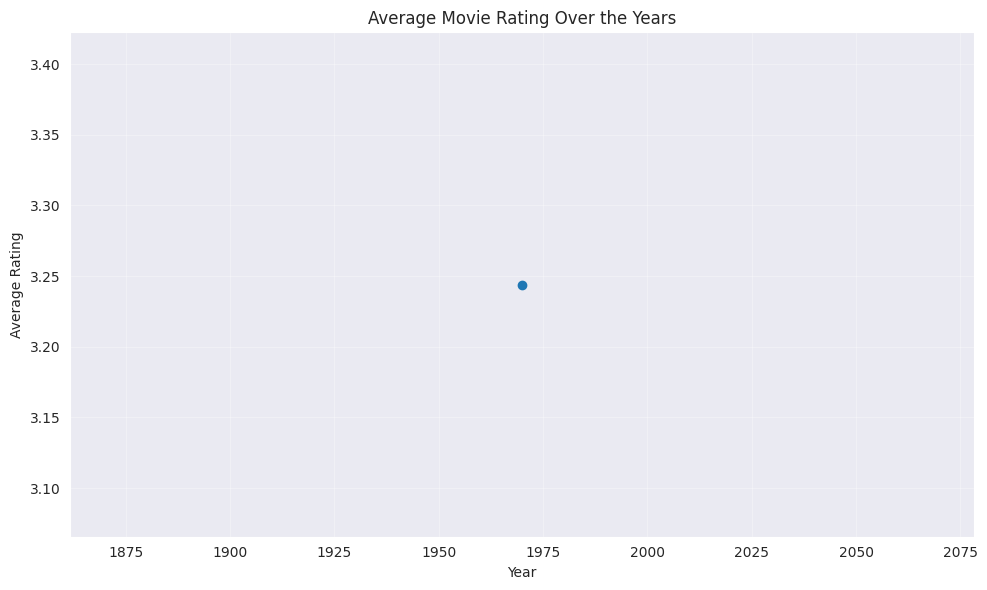

In [67]:
# Filter nulls for 'year' and 'rating'
movies_df['year'] = pd.to_datetime(movies_df['date'], errors='coerce').dt.year
filtered_df = movies_df.dropna(subset=['year', 'rating'])

# Group by year and calculate average rating
average_rating_per_year = filtered_df.groupby('year')['rating'].mean()

# Plot
plt.figure(figsize=(10, 6))
average_rating_per_year.plot(kind='line', marker='o', title='Average Movie Rating Over the Years')
plt.xlabel('Year')
plt.ylabel('Average Rating')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

#### 2.1.8 -  Relationship Between Description Length and Movie Rating.

Correlation between Description Length and Rating: 0.02


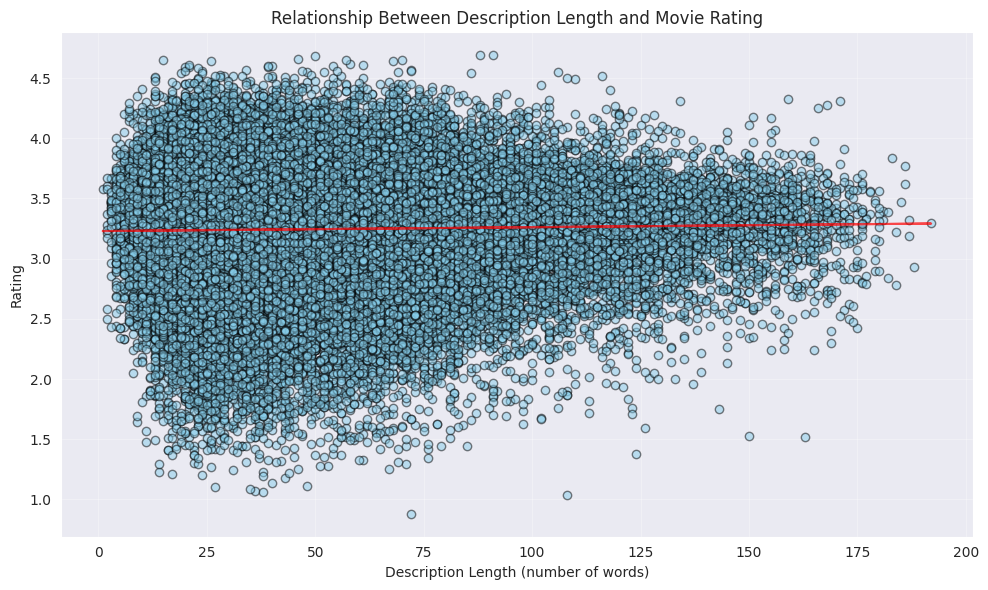

In [68]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Calculate the number of words in each description
movies_df['description_length'] = movies_df['description'].dropna().str.split().apply(len)

# Filter rows with valid 'description_length' and 'rating'
filtered_df = movies_df.dropna(subset=['description_length', 'rating'])

# Calculate correlation
correlation = filtered_df['rating'].corr(filtered_df['description_length'])
print(f"Correlation between Description Length and Rating: {correlation:.2f}")

# Scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(filtered_df['description_length'], filtered_df['rating'], alpha=0.5, color='skyblue', edgecolor='black')
plt.title('Relationship Between Description Length and Movie Rating')
plt.xlabel('Description Length (number of words)')
plt.ylabel('Rating')
plt.grid(alpha=0.3)

# Add trend line
fit = np.polyfit(filtered_df['description_length'], filtered_df['rating'], 1)
plt.plot(filtered_df['description_length'], fit[0] * filtered_df['description_length'] + fit[1], color='red', alpha=0.7)
plt.tight_layout()
plt.show()

If the correlation is strong (positive or negative), it indicates a meaningful relationship between description length and rating.

#### 2.1.9 - Find movies with the most detailed or least detailed descriptions.

In [69]:
# Filter nulls for 'description' and explicitly create a copy
filtered_df = movies_df[movies_df['description'].notnull()].copy()
filtered_df['description_length'] = filtered_df['description'].str.len()

# Identify extremes
longest_descriptions = filtered_df.nlargest(5, 'description_length')
shortest_descriptions = filtered_df.nsmallest(5, 'description_length')

print("Movies with the Longest Descriptions:")
print(longest_descriptions[['name', 'description']])

print("\nMovies with the Shortest Descriptions:")
print(shortest_descriptions[['name', 'description']])

Movies with the Longest Descriptions:
                                 name  \
360495                Swallow the Sun   
184902                    Honey Girls   
248330             Concrete Revolutio   
450029  Bernhard, Scoundrel of Orange   
390687                 Just An Encore   

                                              description  
360495  Jung-woo was abandoned by his birth parents wh...  
184902  The summer of 1986 begins on a promising note ...  
248330  The stage is set in "another Japan" as a banqu...  
450029  Bernhard, schavuit van Oranje is a Dutch telev...  
390687  Ordinary high school student Yan Ze is secretl...  

Movies with the Shortest Descriptions:
                                               name description
165835  Masters of Science Fiction - Little Brother           .
216382  Masters of Science Fiction - A Clean Escape           .
246509       Masters of Science Fiction - Watchbird           .
274919   Masters of Science Fiction - The Awakening        

#### 2.1.10 - Explore the variability in the length of movie taglines and identify movies with the shortest or longest taglines.

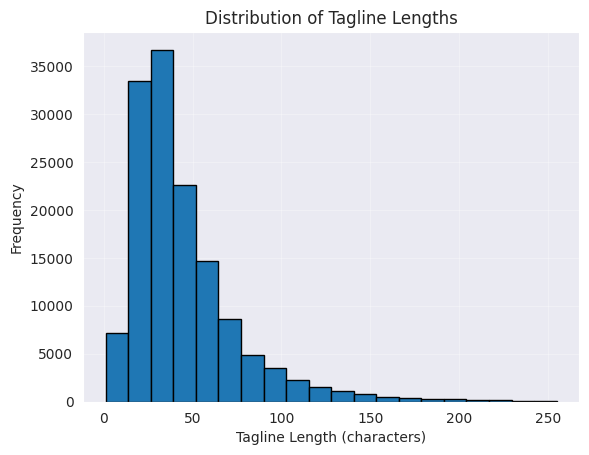

In [70]:
# Filter nulls for 'tagline' and explicitly create a copy
filtered_df = movies_df[movies_df['tagline'].notnull()].copy()
filtered_df['tagline_length'] = filtered_df['tagline'].str.len()

# Plot
filtered_df['tagline_length'].plot(kind='hist', bins=20, title='Distribution of Tagline Lengths', edgecolor='black')
plt.xlabel('Tagline Length (characters)')
plt.ylabel('Frequency')
plt.grid(alpha=0.3)
plt.show()

## 2.2 Actors Dataframe Analysis

In [71]:
actors_df

,id,name,role
0,1000001,Margot Robbie,Barbie
1,1000001,Ryan Gosling,Ken
2,1000001,America Ferrera,Gloria
3,1000001,Ariana Greenblatt,Sasha
4,1000001,Issa Rae,Barbie
...,...,...,...
5798445,1941596,Marc Ma,Ba Cai/巴莱
5798446,1941596,线雨轩,Tata/塔塔
5798447,1941596,Jiang Yixuan,Zuo Yila（Zoila）/佐伊拉
5798448,1941597,Hiroshi Mikami,NaN


#### 2.2.1 - Analyze the length of actor names and identify actors with the shortest and longest names.

Removed 118370 rows with nulls or outliers in 'name_length'.


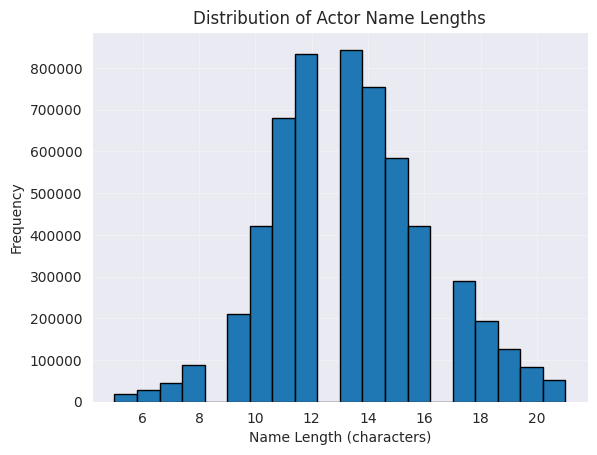


Actors with the Shortest Names:
       name  name_length
33    Mette          5.0
5939  Ayzee          5.0
6377  RiRia          5.0
8474  Akira          5.0
9538  Kurti          5.0

Actors with the Longest Names:
                      name  name_length
32   Hannah Khalique-Brown         21.0
149  Lucia-Rose Sokolowski         21.0
478  Melvin LaThomas Brimm         21.0
551  Matthias Schweighöfer         21.0
595  Maria Teresa Zuppetta         21.0


In [72]:
# Calculate the length of each actor's name
actors_df['name_length'] = actors_df['name'].str.len()

# Remove outliers
q1, q3 = actors_df['name_length'].quantile([0.25, 0.75])
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr
filtered_actors = actors_df[(actors_df['name_length'] >= lower_bound) & (actors_df['name_length'] <= upper_bound)].copy()

print(f"Removed {len(actors_df) - len(filtered_actors)} rows with nulls or outliers in 'name_length'.")

# Plot
filtered_actors['name_length'].plot(kind='hist', bins=20, title='Distribution of Actor Name Lengths', edgecolor='black')
plt.xlabel('Name Length (characters)')
plt.ylabel('Frequency')
plt.grid(alpha=0.3)
plt.show()

# Identify extremes
shortest_names = filtered_actors.nsmallest(5, 'name_length')
longest_names = filtered_actors.nlargest(5, 'name_length')

print("\nActors with the Shortest Names:")
print(shortest_names[['name', 'name_length']])

print("\nActors with the Longest Names:")
print(longest_names[['name', 'name_length']])

#### 2.2.2 - Identify the most common roles played by actors and their frequency.

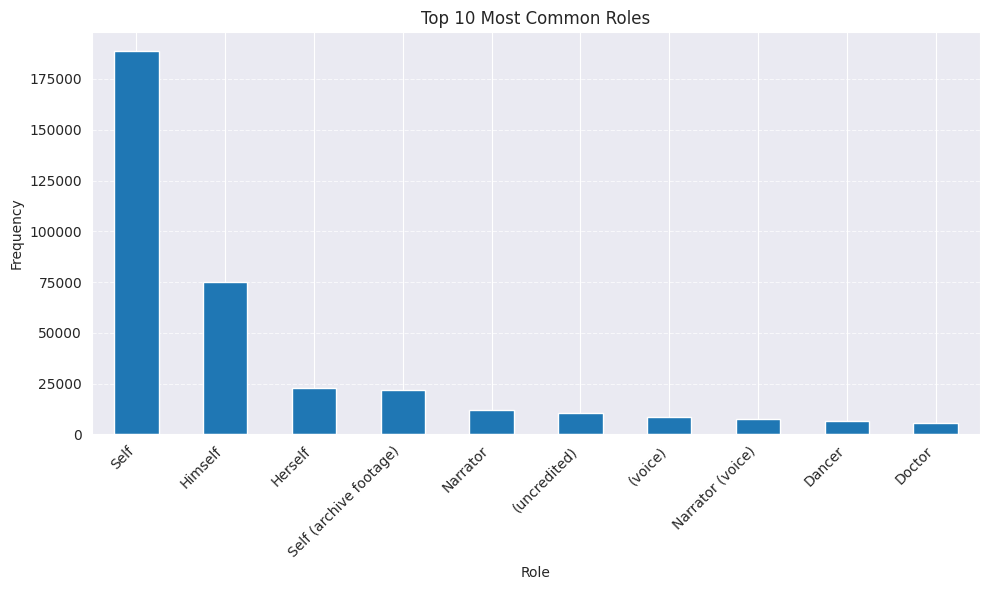


Top 10 Most Common Roles:
role
Self                      188502
Himself                    74829
Herself                    22685
Self (archive footage)     21852
Narrator                   12277
(uncredited)               10816
(voice)                     8436
Narrator (voice)            7569
Dancer                      6875
Doctor                      5742
Name: count, dtype: int64


In [73]:
# Count the frequency of each role
role_counts = actors_df['role'].value_counts()

# Plot the top 10 most common roles
role_counts.head(10).plot(kind='bar', figsize=(10, 6), title='Top 10 Most Common Roles')
plt.xlabel('Role')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

print("\nTop 10 Most Common Roles:")
print(role_counts.head(10))

#### 2.2.3 - Analyze the length of role descriptions and identify the shortest and longest role descriptions.

Removed 1528697 rows with nulls or outliers in 'role_length'.


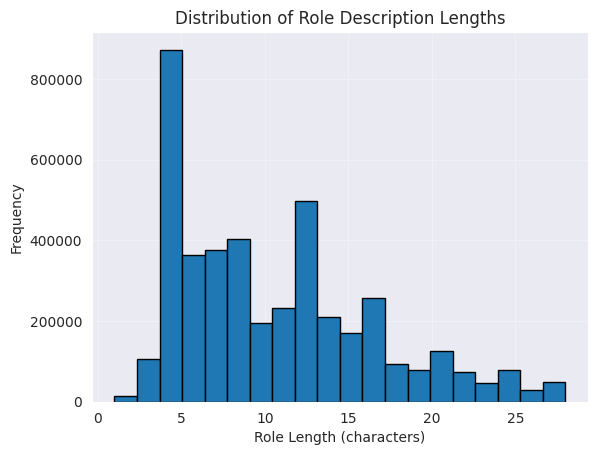


Shortest Role Descriptions:
      role  role_length
25058    M          1.0
25059    Q          1.0
26216    M          1.0
26221    Q          1.0
28740    M          1.0

Longest Role Descriptions:
                             role  role_length
228  Alpha Jumper - Bigger Trophy         28.0
245  Kung Fu Competitor / Co-Star         28.0
294  Salvator - Winking Bartender         28.0
306  Fight Spectator (uncredited)         28.0
317  Fight Spectator (uncredited)         28.0


In [74]:
# Calculate the length of each role description
actors_df['role_length'] = actors_df['role'].str.len()

# Remove outliers
q1, q3 = actors_df['role_length'].quantile([0.25, 0.75])
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr
filtered_actors = actors_df[(actors_df['role_length'] >= lower_bound) & (actors_df['role_length'] <= upper_bound)].copy()

print(f"Removed {len(actors_df) - len(filtered_actors)} rows with nulls or outliers in 'role_length'.")

# Plot
filtered_actors['role_length'].plot(kind='hist', bins=20, title='Distribution of Role Description Lengths', edgecolor='black')
plt.xlabel('Role Length (characters)')
plt.ylabel('Frequency')
plt.grid(alpha=0.3)
plt.show()

# Identify extremes
shortest_roles = filtered_actors.nsmallest(5, 'role_length')
longest_roles = filtered_actors.nlargest(5, 'role_length')

print("\nShortest Role Descriptions:")
print(shortest_roles[['role', 'role_length']])

print("\nLongest Role Descriptions:")
print(longest_roles[['role', 'role_length']])

#### 2.2.4 - Count the number of unique roles and display a few examples.

In [75]:
# Count unique roles
unique_roles = actors_df['role'].nunique()
print(f"Total number of unique roles: {unique_roles}")

# Display examples of unique roles
unique_role_examples = actors_df['role'].dropna().unique()[:10]
print("\nExamples of unique roles:")
print(unique_role_examples)

Total number of unique roles: 1920085

Examples of unique roles:
['Barbie' 'Ken' 'Gloria' 'Sasha' 'Midge' 'Allan' 'Ruth' 'Narrator (voice)'
 'Mattel CEO' 'Aaron Dinkins']


## 2.3 Crew Dataframe Analysis

In [76]:
crew_df.columns

Index(['id', 'role', 'name'], dtype='object')

#### 2.3.1 - Analyze the distribution of crew roles to see which roles are most common.

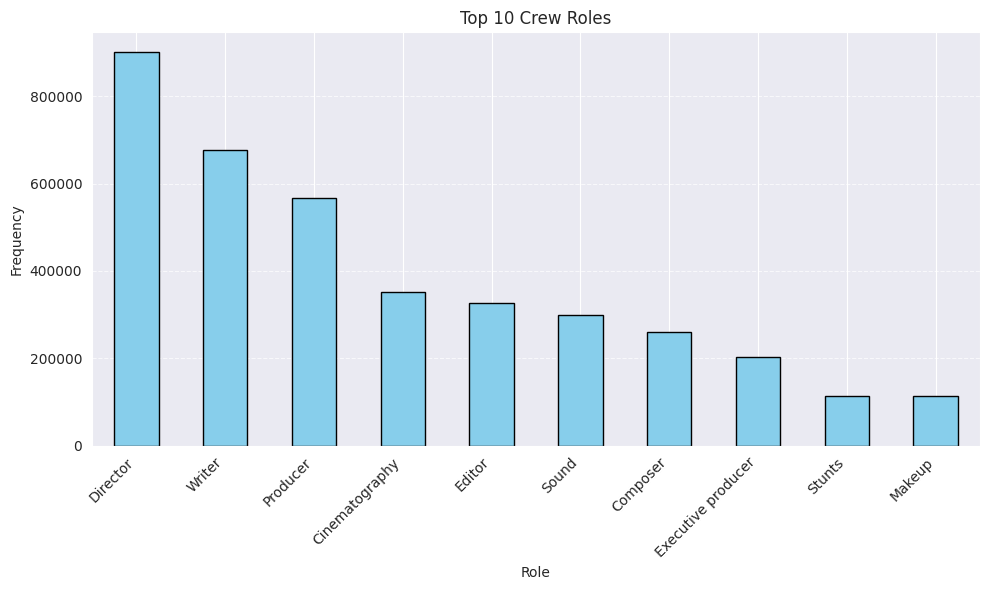


Top 10 Most Common Roles:
role
Director              900753
Writer                677156
Producer              566464
Cinematography        351618
Editor                326088
Sound                 298333
Composer              259650
Executive producer    202770
Stunts                114335
Makeup                113349
Name: count, dtype: int64


In [77]:
import matplotlib.pyplot as plt

# Remove nulls in 'role'
filtered_crew = crew_df.dropna(subset=['role'])

# Count the frequency of each role
role_counts = filtered_crew['role'].value_counts()

# Plot the top 10 most common roles
role_counts.head(10).plot(kind='bar', figsize=(10, 6), color='skyblue', edgecolor='black', title='Top 10 Crew Roles')
plt.xlabel('Role')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

print("\nTop 10 Most Common Roles:")
print(role_counts.head(10))

#### 2.3.2 - Determine the size of the crew for each movie and identify movies with the largest or smallest crews.

Removed 51525 movies with crew sizes as outliers.


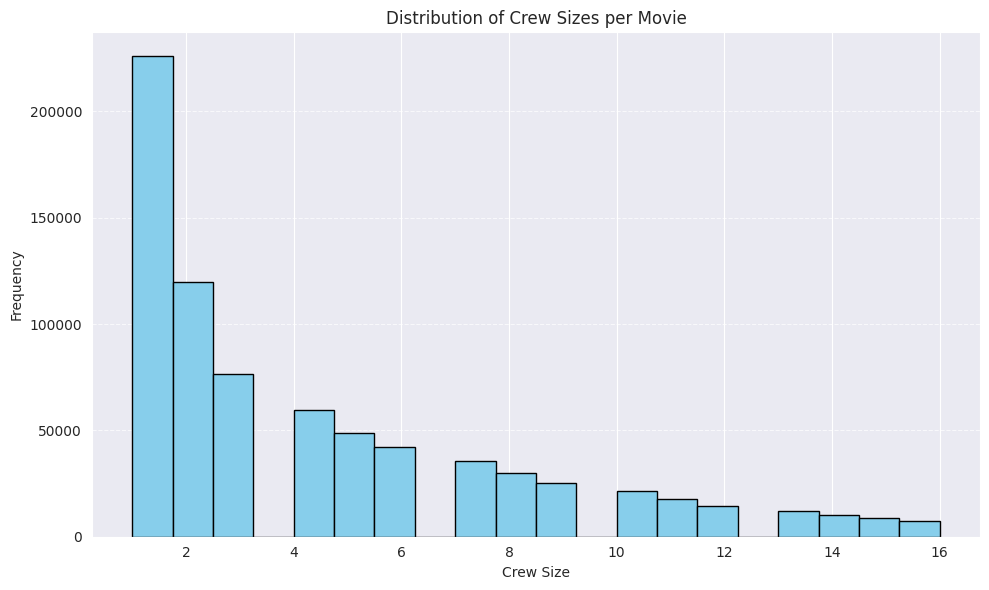


Movies with the Largest Crews:
id
1000040    366
1002278    321
1000254    302
1000513    298
1000065    295
dtype: int64

Movies with the Smallest Crews:
id
1006039    1
1006907    1
1006941    1
1007688    1
1008317    1
dtype: int64


In [80]:
# Remove nulls in 'movie_id'
#filtered_crew = crew_df.dropna(subset=['movie_id'])

# Count crew members per movie
crew_size = crew_df.groupby('id').size()

# Remove outliers using IQR
q1, q3 = crew_size.quantile([0.25, 0.75])
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr
filtered_crew_size = crew_size[(crew_size >= lower_bound) & (crew_size <= upper_bound)]

print(f"Removed {len(crew_size) - len(filtered_crew_size)} movies with crew sizes as outliers.")

# Plot the distribution of crew sizes
plt.figure(figsize=(10, 6))
filtered_crew_size.plot(kind='hist', bins=20, color='skyblue', edgecolor='black', title='Distribution of Crew Sizes per Movie')
plt.xlabel('Crew Size')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Display movies with the largest and smallest crews
largest_crews = crew_size.nlargest(5)
smallest_crews = crew_size.nsmallest(5)

print("\nMovies with the Largest Crews:")
print(largest_crews)

print("\nMovies with the Smallest Crews:")
print(smallest_crews)

#### 2.3.3 - Identify crew members who appear most frequently across movies (e.g., prolific directors or producers).

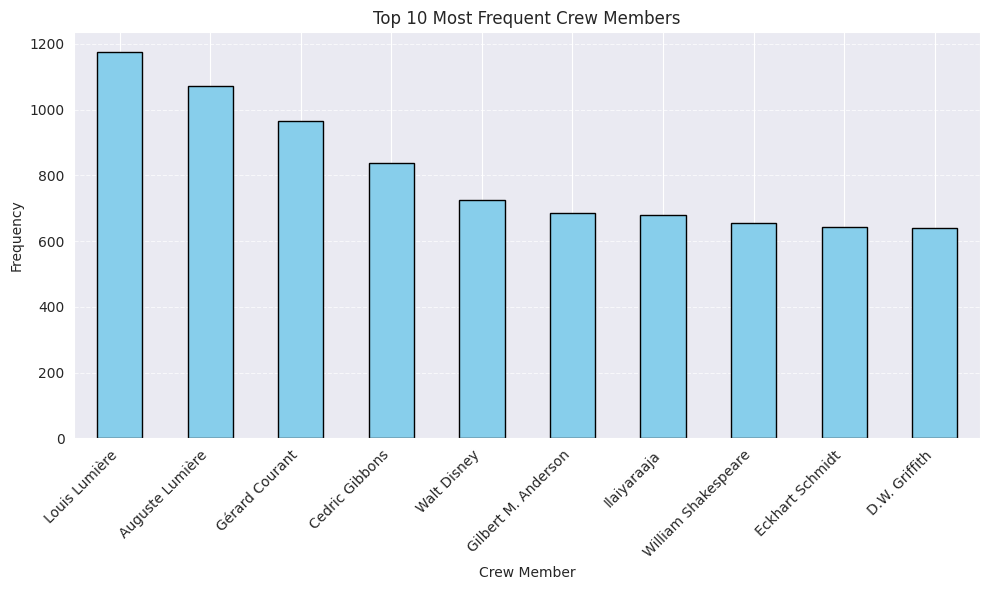


Top 10 Most Frequent Crew Members:
name
Louis Lumière          1176
Auguste Lumière        1072
Gérard Courant          965
Cedric Gibbons          836
Walt Disney             725
Gilbert M. Anderson     685
Ilaiyaraaja             680
William Shakespeare     655
Eckhart Schmidt         643
D.W. Griffith           640
Name: count, dtype: int64


In [81]:
# Remove nulls in 'name'
filtered_crew = crew_df.dropna(subset=['name'])

# Count appearances of each crew member
crew_member_counts = filtered_crew['name'].value_counts()

# Plot the top 10 most frequent crew members
crew_member_counts.head(10).plot(kind='bar', figsize=(10, 6), color='skyblue', edgecolor='black', title='Top 10 Most Frequent Crew Members')
plt.xlabel('Crew Member')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

print("\nTop 10 Most Frequent Crew Members:")
print(crew_member_counts.head(10))

#### 2.3.4 - Analyze the most common roles assigned in movies, highlighting trends in crew composition.

In [84]:
# Remove nulls in 'movie_id' and 'role'
filtered_crew = crew_df.dropna(subset=['id', 'role'])

# Count roles per movie
common_roles_per_movie = filtered_crew.groupby(['id', 'role']).size().reset_index(name='count')

# Find the most common role for each movie
most_common_role = common_roles_per_movie.loc[common_roles_per_movie.groupby('id')['count'].idxmax()]

print("\nMost Common Roles by Movie:")
print(most_common_role.head(10))


Most Common Roles by Movie:
          id             role  count
22   1000001           Stunts     34
45   1000002   Visual effects     16
65   1000003            Sound     11
90   1000004           Stunts     18
113  1000005           Stunts     16
133  1000006   Set decoration     15
157  1000007  Special effects     23
179  1000008            Sound     16
206  1000009           Stunts     89
224  1000010            Sound      8


#### 2.3.5 - Analyze the diversity of roles taken on by individual crew members.

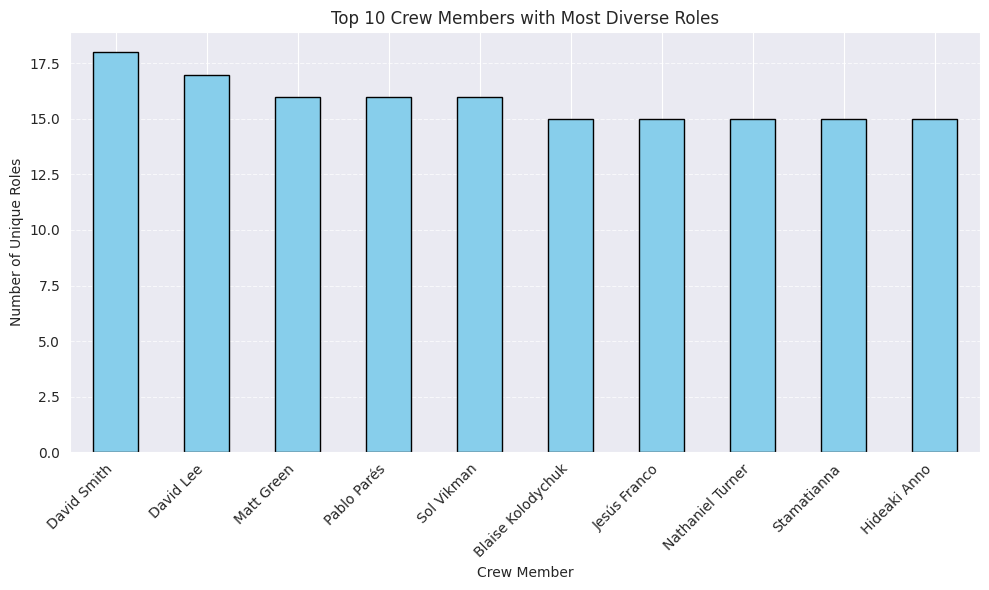


Top 10 Crew Members with the Most Diverse Roles:
name
David Smith          18
David Lee            17
Matt Green           16
Pablo Parés          16
Sol Vikman           16
Blaise Kolodychuk    15
Jesús Franco         15
Nathaniel Turner     15
Stamatianna          15
Hideaki Anno         15
Name: role, dtype: int64


In [85]:
# Remove nulls in 'name' and 'role'
filtered_crew = crew_df.dropna(subset=['name', 'role'])

# Count the number of unique roles for each crew member
crew_role_diversity = filtered_crew.groupby('name')['role'].nunique().sort_values(ascending=False)

# Plot the top 10 crew members with the most diverse roles
crew_role_diversity.head(10).plot(kind='bar', figsize=(10, 6), color='skyblue', edgecolor='black', title='Top 10 Crew Members with Most Diverse Roles')
plt.xlabel('Crew Member')
plt.ylabel('Number of Unique Roles')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

print("\nTop 10 Crew Members with the Most Diverse Roles:")
print(crew_role_diversity.head(10))

#### 2.3.6 - Analyze how frequently crew members collaborate on the same movies.

In [87]:
from itertools import combinations
from collections import Counter

# Remove nulls in 'movie_id' and 'name'
filtered_crew = crew_df.dropna(subset=['id', 'name'])

# Create pairs of crew members for each movie
crew_collaborations = filtered_crew.groupby('id')['name'].apply(lambda x: list(combinations(sorted(x), 2)))

# Flatten the list of pairs and count collaborations
collaboration_counts = Counter([pair for sublist in crew_collaborations for pair in sublist])

# Convert to a DataFrame
collaboration_df = pd.DataFrame(collaboration_counts.items(), columns=['Pair', 'Count']).sort_values(by='Count', ascending=False)

print("\nTop 10 Crew Collaborations:")
print(collaboration_df.head(10))


Top 10 Crew Collaborations:
                                          Pair  Count
8365088       (Auguste Lumière, Louis Lumière)   1516
17737077      (Gérard Courant, Gérard Courant)   1284
9215894     (Eckhart Schmidt, Eckhart Schmidt)    849
17387596  (Petter Baiestorf, Petter Baiestorf)    731
24201080        (Eldar Bogunov, Eldar Bogunov)    591
2520636        (Joseph Barbera, William Hanna)    517
2073644      (Cedric Gibbons, Edwin B. Willis)    489
26234072        (Danilo Macuco, Danilo Macuco)    467
9098421           (Jesús Franco, Jesús Franco)    457
12102628                (Eli Hayes, Eli Hayes)    444


## 2.4 Languages Dataframe Analysis

In [88]:
languages_df

,id,type,language
0,1000001,Language,English
1,1000002,Primary language,Korean
2,1000002,Spoken language,English
3,1000002,Spoken language,German
4,1000002,Spoken language,Korean
...,...,...,...
1038757,1941593,Language,Chinese
1038758,1941594,Language,English
1038759,1941595,Language,English
1038760,1941596,Language,Chinese


In [89]:
languages_df.columns

Index(['id', 'type', 'language'], dtype='object')

#### 2.4.1 - Analyze the distribution of languages in movies to see which are most commonly used.

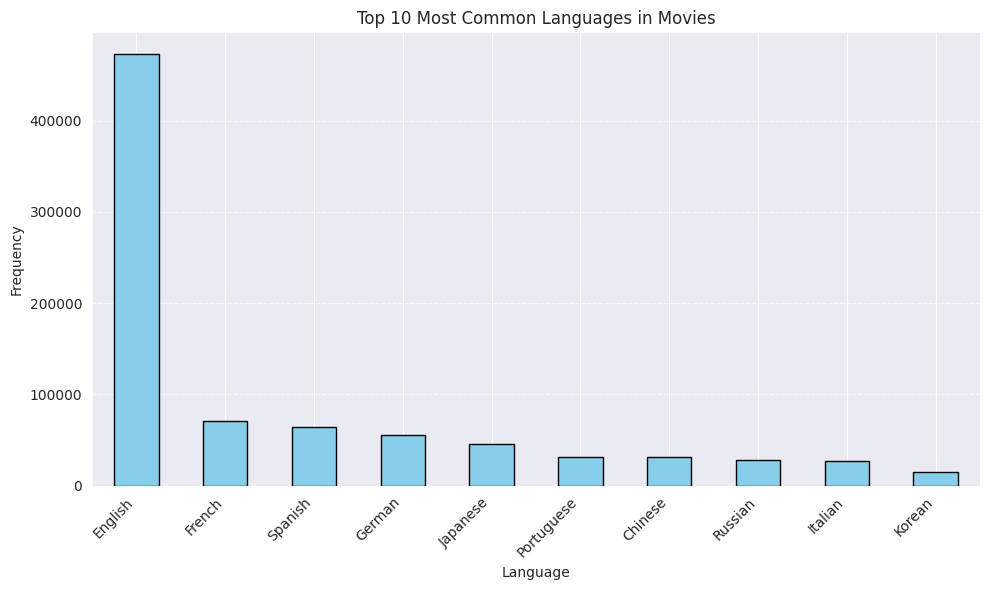


Top 10 Most Common Languages:
language
English       473068
French         70487
Spanish        64539
German         55524
Japanese       45287
Portuguese     31670
Chinese        31628
Russian        27820
Italian        27208
Korean         14740
Name: count, dtype: int64


In [90]:
import matplotlib.pyplot as plt

# Remove nulls in 'language'
filtered_languages = languages_df.dropna(subset=['language'])

# Count the frequency of each language
language_counts = filtered_languages['language'].value_counts()

# Plot the top 10 most common languages
language_counts.head(10).plot(kind='bar', figsize=(10, 6), color='skyblue', edgecolor='black', title='Top 10 Most Common Languages in Movies')
plt.xlabel('Language')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

print("\nTop 10 Most Common Languages:")
print(language_counts.head(10))

#### 2.4.2 - Explore how different types of languages (e.g., “Spoken”, “Subtitled”) are distributed in movies.

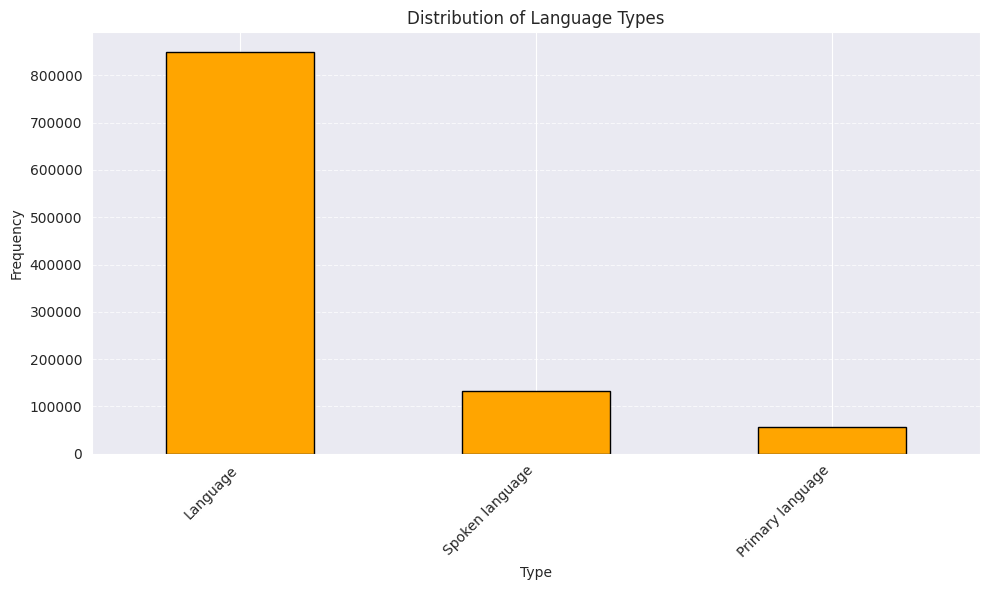


Distribution of Language Types:
type
Language            848466
Spoken language     133185
Primary language     57111
Name: count, dtype: int64


In [91]:
# Remove nulls in 'type'
filtered_types = languages_df.dropna(subset=['type'])

# Count the frequency of each type
type_counts = filtered_types['type'].value_counts()

# Plot the distribution of language types
type_counts.plot(kind='bar', figsize=(10, 6), color='orange', edgecolor='black', title='Distribution of Language Types')
plt.xlabel('Type')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

print("\nDistribution of Language Types:")
print(type_counts)

#### 2.4.3 - Calculate the average number of languages associated with each type (Spoken, Subtitled, etc.) and compare the results.

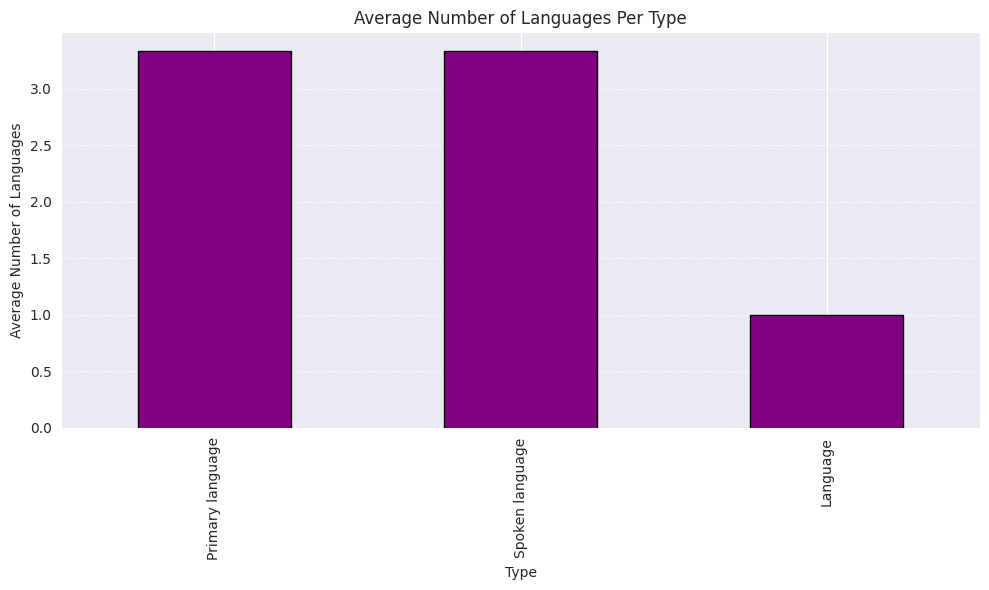


Average Number of Languages Per Type:
type
Primary language    3.332020
Spoken language     3.331979
Language            1.000000
Name: language_count, dtype: float64


In [94]:
# Remove nulls in 'type' and 'movie_id'
filtered_languages = languages_df.dropna(subset=['type', 'id'])

# Calculate the number of languages per movie
languages_per_movie = filtered_languages.groupby('id').size().rename('language_count')  # Ensure the Series has a name

# Merge the language counts with the type of language
movie_types = filtered_languages[['id', 'type']].drop_duplicates()
languages_with_type = pd.merge(movie_types, languages_per_movie, left_on='id', right_index=True, how='inner')

# Calculate the average number of languages per type
average_languages_per_type = languages_with_type.groupby('type')['language_count'].mean().sort_values(ascending=False)

# Plot the results
plt.figure(figsize=(10, 6))
average_languages_per_type.plot(kind='bar', color='purple', edgecolor='black', title='Average Number of Languages Per Type')
plt.xlabel('Type')
plt.ylabel('Average Number of Languages')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

print("\nAverage Number of Languages Per Type:")
print(average_languages_per_type)

#### 2.4.4 - Identify the most frequent combinations of languages used together in movies.

In [97]:
from itertools import combinations
from collections import Counter

# Group languages by movie and find combinations
filtered_languages = languages_df.dropna(subset=['id', 'language'])
language_combinations = filtered_languages.groupby('id')['language'].apply(lambda x: list(combinations(sorted(x), 2)))

# Flatten the list of combinations and count frequencies
combination_counts = Counter([pair for sublist in language_combinations for pair in sublist])

# Convert to DataFrame
combination_df = pd.DataFrame(combination_counts.items(), columns=['Combination', 'Count']).sort_values(by='Count', ascending=False)

print("\nTop 10 Most Common Language Combinations:")
print(combination_df.head(10))


Top 10 Most Common Language Combinations:
             Combination  Count
7     (English, English)  21423
9      (English, French)  15942
10    (English, Spanish)  12686
0      (English, German)  11780
22    (English, Italian)   6308
67      (French, French)   5181
29      (French, German)   4392
12   (English, Japanese)   4136
103     (German, German)   3913
6     (Chinese, English)   3601


## 2.5 Dataframe Analysis

In [98]:
posters_df

,id,link
0,1000001,https://a.ltrbxd.com/resized/film-poster/2/7/7...
1,1000002,https://a.ltrbxd.com/resized/film-poster/4/2/6...
2,1000003,https://a.ltrbxd.com/resized/film-poster/4/7/4...
3,1000004,https://a.ltrbxd.com/resized/film-poster/5/1/5...
4,1000005,https://a.ltrbxd.com/resized/film-poster/2/4/0...
...,...,...
941592,1941593,NaN
941593,1941594,NaN
941594,1941595,https://a.ltrbxd.com/resized/film-poster/1/1/8...
941595,1941596,https://a.ltrbxd.com/resized/film-poster/1/1/8...


## 2.6 Releases Dataframe Analysis

In [99]:
releases_df.columns

Index(['id', 'country', 'date', 'type', 'rating'], dtype='object')

 #### 2.6.1 - Analyze which countries have the most releases.

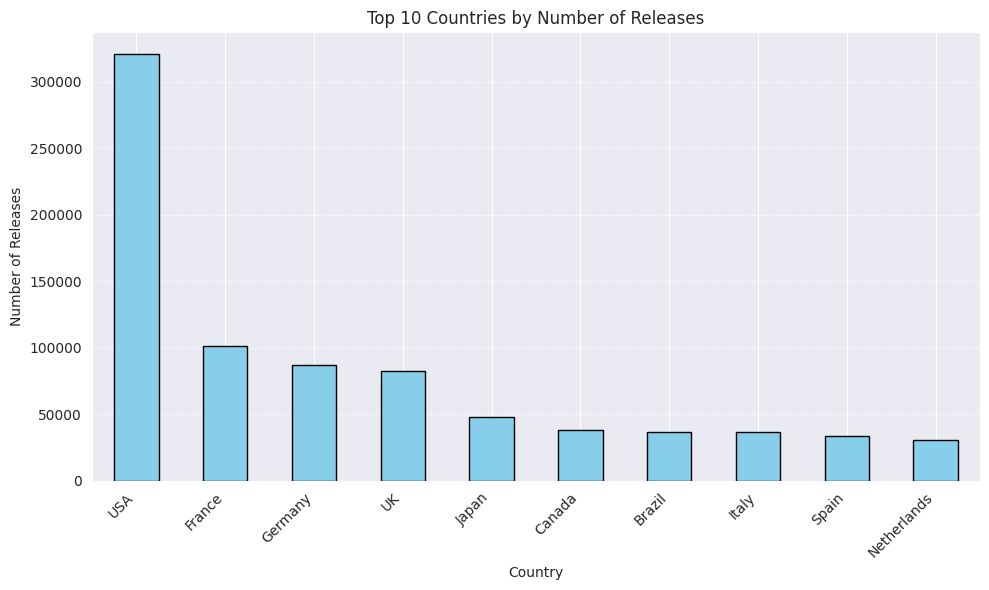


Top 10 Countries by Number of Releases:
country
USA            320901
France         101670
Germany         87159
UK              82682
Japan           48026
Canada          38013
Brazil          37087
Italy           36628
Spain           34019
Netherlands     30948
Name: count, dtype: int64


In [100]:
import matplotlib.pyplot as plt

# Remove nulls in 'country'
filtered_releases = releases_df.dropna(subset=['country'])

# Count the number of releases per country
country_counts = filtered_releases['country'].value_counts()

# Plot the top 10 countries with the most releases
country_counts.head(10).plot(kind='bar', figsize=(10, 6), color='skyblue', edgecolor='black', title='Top 10 Countries by Number of Releases')
plt.xlabel('Country')
plt.ylabel('Number of Releases')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

print("\nTop 10 Countries by Number of Releases:")
print(country_counts.head(10))

  #### 2.6.2 - Analyze how the number of releases has changed over the years.

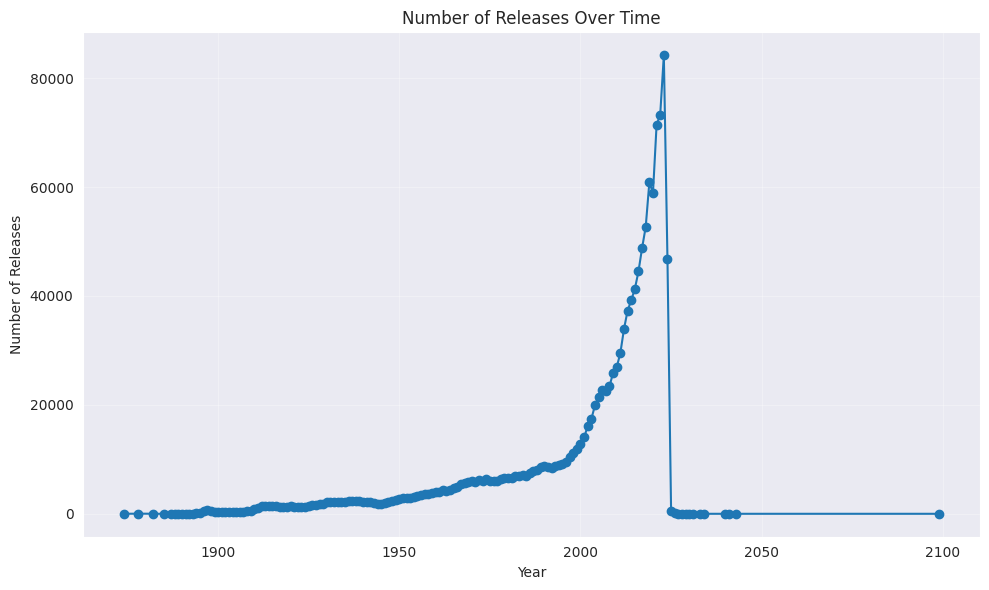


Releases Per Year:
year
2028    6
2029    6
2030    3
2031    4
2033    3
2034    1
2040    2
2041    2
2043    1
2099    2
dtype: int64


In [101]:
# Ensure 'year' column exists
releases_df['year'] = pd.to_datetime(releases_df['date'], errors='coerce').dt.year

# Remove nulls in 'year'
filtered_releases = releases_df.dropna(subset=['year'])

# Count the number of releases per year
releases_per_year = filtered_releases.groupby('year').size()

# Plot the trends over time
plt.figure(figsize=(10, 6))
releases_per_year.plot(kind='line', marker='o', title='Number of Releases Over Time')
plt.xlabel('Year')
plt.ylabel('Number of Releases')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print("\nReleases Per Year:")
print(releases_per_year.tail(10))

   #### 2.6.3 - Analyze the distribution of release types (e.g., theatrical, streaming, etc.).

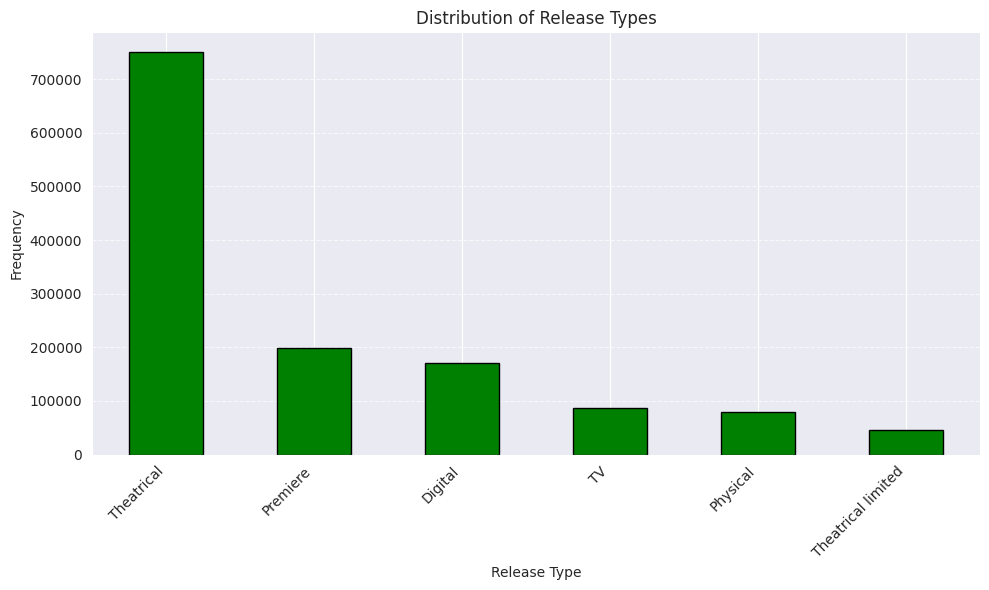


Distribution of Release Types:
type
Theatrical            750043
Premiere              198706
Digital               169986
TV                     87641
Physical               79769
Theatrical limited     46637
Name: count, dtype: int64


In [102]:
# Remove nulls in 'type'
filtered_releases = releases_df.dropna(subset=['type'])

# Count the frequency of each release type
type_counts = filtered_releases['type'].value_counts()

# Plot the distribution of release types
type_counts.plot(kind='bar', figsize=(10, 6), color='green', edgecolor='black', title='Distribution of Release Types')
plt.xlabel('Release Type')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

print("\nDistribution of Release Types:")
print(type_counts)

   #### 2.6.4 - Compare the average rating of movies across different release types.

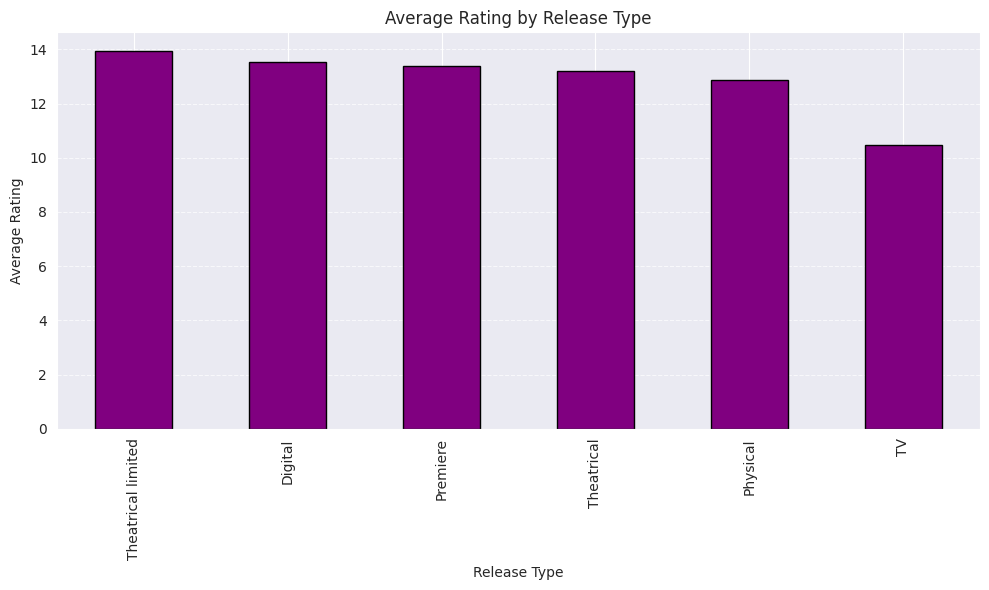


Average Rating by Release Type:
type
Theatrical limited    13.930782
Digital               13.517900
Premiere              13.385402
Theatrical            13.187313
Physical              12.864154
TV                    10.466321
Name: rating, dtype: float64


In [103]:
# Remove nulls in 'type' and 'rating' and create a copy to avoid warnings
filtered_releases = releases_df.dropna(subset=['type', 'rating']).copy()

# Convert 'rating' to numeric, coercing errors to NaN
filtered_releases['rating'] = pd.to_numeric(filtered_releases['rating'], errors='coerce')

# Remove rows with invalid ratings
filtered_releases = filtered_releases.dropna(subset=['rating'])

# Calculate the average rating for each release type
average_rating_by_type = filtered_releases.groupby('type')['rating'].mean().sort_values(ascending=False)

# Plot the results
plt.figure(figsize=(10, 6))
average_rating_by_type.plot(kind='bar', color='purple', edgecolor='black', title='Average Rating by Release Type')
plt.xlabel('Release Type')
plt.ylabel('Average Rating')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

print("\nAverage Rating by Release Type:")
print(average_rating_by_type)

   #### 2.6.5 - Analyze release trends for a specific country over time.

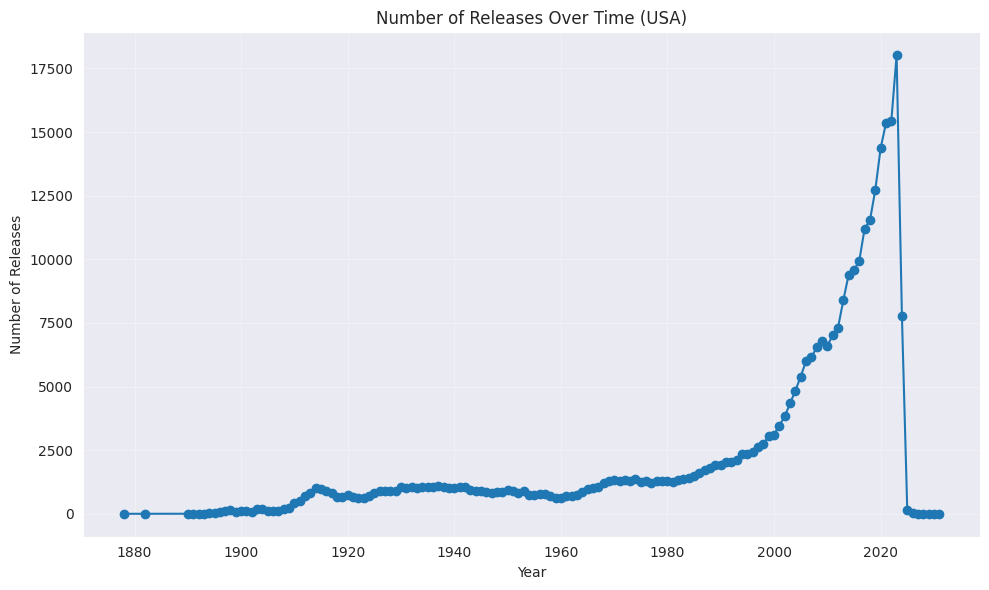


Releases Per Year (USA):
year
2022    15415
2023    18017
2024     7756
2025      138
2026       31
2027        5
2028        2
2029        2
2030        2
2031        1
dtype: int64


In [104]:
# Ensure 'year' column exists
releases_df['year'] = pd.to_datetime(releases_df['date'], errors='coerce').dt.year

# Filter for a specific country (e.g., 'USA')
filtered_country = releases_df[releases_df['country'] == 'USA']

# Count the number of releases per year for the country
releases_per_year_country = filtered_country.groupby('year').size()

# Plot the trends over time for the selected country
plt.figure(figsize=(10, 6))
releases_per_year_country.plot(kind='line', marker='o', title='Number of Releases Over Time (USA)')
plt.xlabel('Year')
plt.ylabel('Number of Releases')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print("\nReleases Per Year (USA):")
print(releases_per_year_country.tail(10))